# Exercises

file name: time_series_anomaly_detection.py or time_series_anomaly_detection.ipynb

Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

Bonus:

Can you label students who are viewing both the web dev and data science curriculum? Can you label students by the program they are in? Can you label users by student vs. staff? What are Zach, Maggie, Faith, and Ryan's ids?

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
import seaborn as sns

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

## Wrangle Data

In [2]:
# this works, but getting from curriculum
colnames=['date', 'hour', 'page_viewed', 'user_id', 'cohort', 'IP']
df = pd.read_csv('anonymized-curriculum-access.txt', sep=' ', header=None, names=colnames)

In [3]:
df['date_time'] = df['date'] + ' ' + df['hour']

In [4]:
del df['date']
del df['hour']

In [5]:
df.date_time = pd.to_datetime(df.date_time) 
df = df.set_index('date_time')

In [6]:
df.head()

,page_viewed,user_id,cohort,IP
date_time,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [7]:
# from appendix
colnames=['date','page_viewed','user_id','cohort_id','ip']
df_cirric = pd.read_csv('anonymized-curriculum-access.txt',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0,2,3,4,5]
)

In [8]:
df_cirric.head()

,date,page_viewed,user_id,cohort_id,ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 719459 entries, 2018-01-26 09:55:03 to 2020-11-02 16:48:47
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   page_viewed  719458 non-null  object 
 1   user_id      719459 non-null  int64  
 2   cohort       674619 non-null  float64
 3   IP           719459 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 27.4+ MB


In [10]:
df.isna().sum()

page_viewed        1
user_id            0
cohort         44840
IP                 0
dtype: int64

In [11]:
missing_cohort = df[df['cohort'].isnull()]
missing_cohort

,page_viewed,user_id,cohort,IP
date_time,,,,
2018-01-26 16:46:16,/,48,NaN,97.105.19.61
2018-01-26 16:46:24,spring/extra-features/form-validation,48,NaN,97.105.19.61
2018-01-26 17:54:24,/,48,NaN,97.105.19.61
2018-01-26 18:32:03,/,48,NaN,97.105.19.61
2018-01-26 18:32:17,mysql/relationships/joins,48,NaN,97.105.19.61
...,...,...,...,...
2020-11-02 16:02:22,java-iii,717,NaN,136.50.18.157
2020-11-02 16:02:26,java-iii/servlets,717,NaN,136.50.18.157
2020-11-02 16:03:50,appendix/further-reading/java/intellij-tomcat-...,727,NaN,70.94.165.107


In [12]:
# almost 45,000 records missing cohort id, fill with 0 for now
df = df.fillna(0)
# change to integer instead of float
df.cohort = df.cohort.astype('int')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 719459 entries, 2018-01-26 09:55:03 to 2020-11-02 16:48:47
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   page_viewed  719459 non-null  object
 1   user_id      719459 non-null  int64 
 2   cohort       719459 non-null  int64 
 3   IP           719459 non-null  object
dtypes: int64(2), object(2)
memory usage: 27.4+ MB


## compute entropy

In [20]:
# function to compute entropy from lesson

def compute_entropy(series):
    counts = series.value_counts()
    if len(counts)==1:
        ent = 0
    else:
        value, counts = np.unique(series, return_counts=True)
        ent = entropy(counts, base=None)
    return ent

In [21]:
compute_entropy(df.IP)

4.281933437860451

In [22]:
compute_entropy(df.cohort)

3.235242786918197

In [23]:
compute_entropy(df.user_id)

6.170031470548415

## Split data?

In [52]:
train = df[:'2019-07-17']
validate = df['2019-07-18':'2020-03-15']
test = df['2020-03-16':]

In [53]:
train.head()

,page_viewed,user_id,cohort,IP
date_time,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61


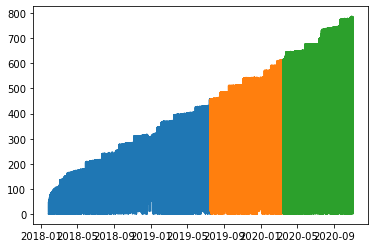

In [54]:
plt.plot(train.index, train.user_id)
plt.plot(validate.index, validate.user_id)
plt.plot(test.index, test.user_id)

In [30]:
train.IP.value_counts()
# https://iplocation.com/
# https://iplocation.com/
# 3rd IP listed is for Codeup downtown

97.105.19.58       209622
97.105.19.61        61662
192.171.117.210      7947
70.122.40.62         1331
66.69.108.117        1199
                    ...  
136.50.0.214            1
72.181.100.92           1
173.239.232.7           1
165.237.199.139         1
174.207.25.208          1
Name: IP, Length: 2457, dtype: int64

In [32]:
# not sure what to do with this
train_agg = train.groupby(['date_time','cohort'])['user_id'].\
                        nunique().\
                    reset_index().\
                    rename(index=str, 
                       columns={'user_id': 'users_viewed'})

In [33]:
train_agg
# this is the number of unique user_id's for each cohort in the dataset
# 0 has so many because there was no cohort id for these users, might be instructors?
# cohort 1 is 1st cohort started in 2014, so odd that 18 people with that id would be continuing to access



,date_time,cohort,users_viewed
0,2018-01-26 09:55:03,8,1
1,2018-01-26 09:56:02,8,1
2,2018-01-26 09:56:05,8,1
3,2018-01-26 09:56:06,8,1
4,2018-01-26 09:56:24,22,1
...,...,...,...
364361,2019-10-17 22:45:35,29,1
364362,2019-10-17 23:01:57,17,1
364363,2019-10-17 23:02:02,17,1
364364,2019-10-17 23:02:04,17,1


In [34]:
train['month'] = train.index.month
train['weekday'] = train.index.day_name()
train['hour'] = train.index.hour
train['day'] = train.index.day
train['year'] = train.index.year


In [35]:
train.head()

,page_viewed,user_id,cohort,IP,month,weekday,hour
date_time,,,,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61,1,Friday,9
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,1,Friday,9
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,1,Friday,9
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,1,Friday,9
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,1,Friday,9


<AxesSubplot:xlabel='cohort', ylabel='hour'>

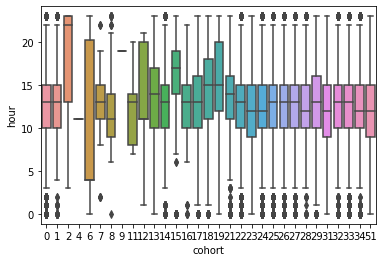

In [39]:
sns.boxplot(data=train, y='hour', x='cohort')

<AxesSubplot:xlabel='cohort', ylabel='weekday'>

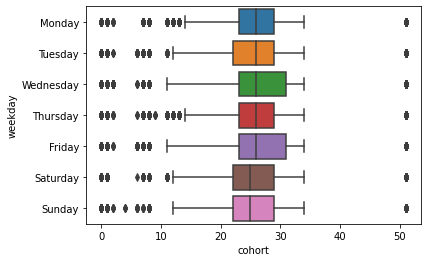

In [41]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(data=train, y='weekday', x='cohort', order=order)

In [42]:
train.cohort.value_counts()

29    35447
24    34991
22    28846
23    27983
33    27137
26    26448
0     26409
32    26040
25    25226
31    22327
27    20157
28    18609
34    11105
1      8876
14     8791
21     7138
51     6150
17     3520
13     2539
8      1671
18     1602
19     1142
16      740
15      691
7       433
12      270
11      204
2        93
6        72
9         5
4         4
Name: cohort, dtype: int64

In [ ]:
# y =  count of user_id 

In [ ]:
y.resample('M').agg(['min', 'mean', 'max']).plot()